## Prediction of Wine Shop Varieties

In [1]:
#All Imports
import os
import re
import string
import pickle
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from textblob import TextBlob
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.preprocessing import LabelEncoder,StandardScaler
plt.rcParams["figure.figsize"] = (10,7)
%matplotlib inline

In [2]:
## Get File details in the current working directory
def find_files():
    cwd=os.getcwd()
    files=os.listdir(cwd)
    return files

## Read_the_data

In [3]:

train_df=pd.read_csv("Data/train.csv")
test_df=pd.read_csv("Data/test.csv")

## Data Cleaning

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82657 entries, 0 to 82656
Data columns (total 12 columns):
user_name             63264 non-null object
country               82622 non-null object
review_title          82657 non-null object
review_description    82657 non-null object
designation           59010 non-null object
points                82657 non-null int64
price                 77088 non-null float64
province              82622 non-null object
region_1              69903 non-null object
region_2              35949 non-null object
winery                82657 non-null object
variety               82657 non-null object
dtypes: float64(1), int64(1), object(10)
memory usage: 7.6+ MB


In [5]:
train_df.shape

(82657, 12)

In [6]:
train_df.head()

,user_name,country,review_title,review_description,designation,points,price,province,region_1,region_2,winery,variety
0,NaN,Australia,Andrew Peace 2007 Peace Family Vineyard Chardo...,"Classic Chardonnay aromas of apple, pear and h...",Peace Family Vineyard,83,10.0,Australia Other,South Eastern Australia,NaN,Andrew Peace,Chardonnay
1,@wawinereport,US,North by Northwest 2014 Red (Columbia Valley (...,This wine is near equal parts Syrah and Merlot...,NaN,89,15.0,Washington,Columbia Valley (WA),Columbia Valley,North by Northwest,Red Blend
2,NaN,Italy,Renato Ratti 2007 Conca (Barolo),Barolo Conca opens with inky dark concentratio...,Conca,94,80.0,Piedmont,Barolo,NaN,Renato Ratti,Nebbiolo
3,@vossroger,France,Domaine l'Ancienne Cure 2010 L'Abbaye White (B...,It's impressive what a small addition of Sauvi...,L'Abbaye,87,22.0,Southwest France,Bergerac Sec,NaN,Domaine l'Ancienne Cure,Bordeaux-style White Blend
4,@vossroger,France,Château du Cèdre 2012 Le Cèdre Vintage Malbec ...,"This ripe, sweet wine is rich and full of drie...",Le Cèdre Vintage,88,33.0,France Other,Vin de Liqueur,NaN,Château du Cèdre,Malbec


## Plot Country Wise data

In [7]:
wn_country = train_df.groupby(['country']).count()[["province"]].apply(lambda x : 100*x/x.sum())
wn_country.head()

,province
country,
Argentina,3.110552
Australia,1.244221
Austria,2.289947
Brazil,0.033889
Bulgaria,0.112561


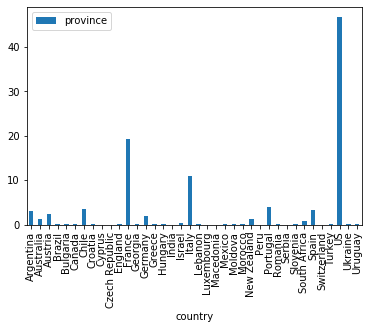

In [8]:
#Plot Normalized Data

wn_country.plot(kind='bar')


## Classification based on prices by country

In [9]:
mx=train_df.iloc[train_df["price"].idxmax(),1]
mn=train_df.iloc[train_df["price"].idxmin(),1]
print("Cheapest wines is sold  in \"{}\" - {:g}$.\n".format(mn,min(train_df["price"])))
print("Costliest wines is sold  in \"{}\" - {:g}$.\n".format(mx,max(train_df["price"])))

Cheapest wines is sold  in "US" - 4$.

Costliest wines is sold  in "France" - 3300$.



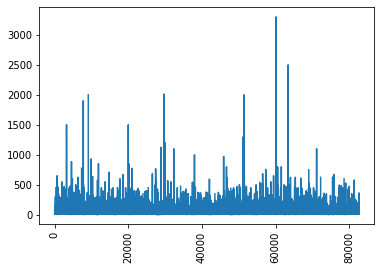

In [18]:
plt.xticks(rotation=90)
plt.plot(train_df["price"])


In [11]:

price_df = train_df.groupby(['country']).mean()[["price"]]
max_price=price_df["price"].idxmax()
min_price=price_df["price"].idxmin()
print("Cheaper wines are sold (On Average) in \"{}\" - {:g}$.\n".format(min_price,min(price_df["price"])))
print("Costlier wines are sold (On Average) in \"{}\" - {:g}$.\n".format(max_price,max(price_df["price"])))

Cheaper wines are sold (On Average) in "Ukraine" - 9.27273$.

Costlier wines are sold (On Average) in "Switzerland" - 107.8$.



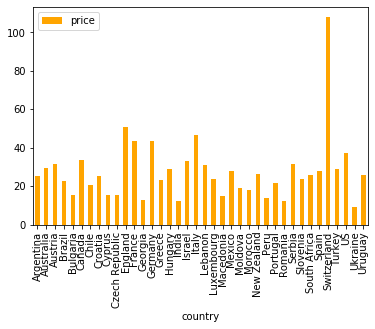

In [19]:
price_df.plot(kind="bar",color="orange")

## Ratings by Country

In [20]:

rating_df = train_df.groupby(['country']).mean()[["points"]]
max_rate=rating_df["points"].idxmax()
min_rate=rating_df["points"].idxmin()
print("Bad ratings are given (On Average) in \"{}\" - {:g}.\n".format(min_rate,min(rating_df["points"])))
print("Good ratings are given (On Average) in \"{}\" - {:g}.\n".format(max_rate,max(rating_df["points"])))

Bad ratings are given (On Average) in "Peru" - 82.625.

Good ratings are given (On Average) in "England" - 91.4516.



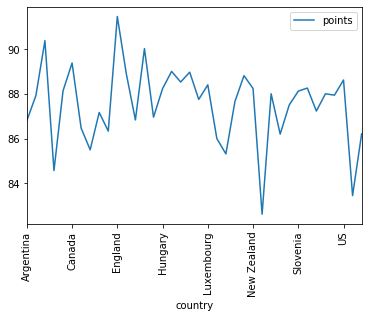

In [22]:
rating_df.plot(rot=90)

## Most Common Winery

In [23]:
#Function to get the most common item

def get_most_common_item(df):
    c=Counter(df)
    return c.most_common()

In [26]:
cw=get_most_common_item(train_df["winery"])
print("\nMost wine trade is from \"{}\" with a count of {}.\n".format(cw[0][0],cw[0][1]))


Most wine trade is from "Testarossa" with a count of 175.



In [27]:
items_by_winery = train_df.groupby(['country'])[['winery']].count().apply(lambda x : 100*x/x.sum())
items_by_winery.head()

,winery
country,
Argentina,3.110552
Australia,1.244221
Austria,2.289947
Brazil,0.033889
Bulgaria,0.112561


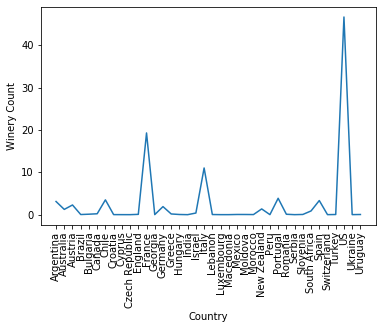

In [28]:
plt.xticks(rotation=90)
plt.xlabel("Country")
plt.ylabel("Winery Count")
plt.plot(items_by_winery)

## Insights
- From the above plot we can say that US has higest number of winerys

In [29]:
vc=get_most_common_item(train_df["variety"])
print("\nMost wine trade is from \"{}\" with a count of {}.\n".format(vc[0][0],vc[0][1]))


Most wine trade is from "Pinot Noir" with a count of 10587.



In [30]:
items_by_variety = train_df.groupby(['country'])[['variety']].size()
items_by_variety.head()

country
Argentina    2570
Australia    1028
Austria      1892
Brazil         28
Bulgaria       93
dtype: int64

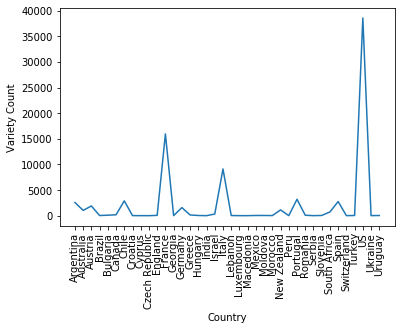

In [31]:
#Plots
plt.xticks(rotation=90)
plt.xlabel("Country")
plt.ylabel("Variety Count")
plt.plot(items_by_variety)

## Insights
- It is sure that the country with highest number of winerys has more number of varieties than others.
- US has large amount of varieties of wines.

## Plot on No of provinces in each country.

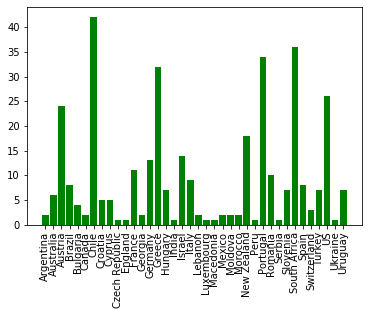

In [32]:

items_by_c=train_df.groupby(['country','province'])['variety'].unique()
tst=items_by_c.index
location_cluster={}
for i in tst:
    if(i[0]) in location_cluster:
        
        location_cluster[i[0]]+=1
    else:
        location_cluster[i[0]]=1
        
plt.bar(location_cluster.keys(), location_cluster.values(), color='g')
plt.xticks(rotation=90)
plt.show()

## No of Varieties classification based on country

In [33]:
items_by_v=train_df.groupby(['country'])['variety'].count()
items_by_v.head()

country
Argentina    2570
Australia    1028
Austria      1892
Brazil         28
Bulgaria       93
Name: variety, dtype: int64

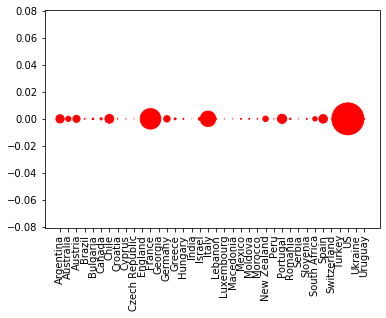

In [34]:
cnt=1
var_cnt=[]
for i in items_by_v.index:
    var_cnt.append(i)
    cnt+=2
x = var_cnt
y = [0]*len(x)
n=len(y)
s = [i/n for i in items_by_v]
plt.scatter(x,y,s=s,color='r')
plt.xticks(rotation=90)
plt.show()

- Plot which shows the total number of varieties by country.
- Larger the size of circle, more no of varieties in that country

## Drop the columns which are not necesssary

In [35]:
train_df.columns

Index(['user_name', 'country', 'review_title', 'review_description',
       'designation', 'points', 'price', 'province', 'region_1', 'region_2',
       'winery', 'variety'],
      dtype='object')

In [36]:
def drop_cols(df,cols):
    return df.drop(columns=cols)

In [37]:
#Remove the Unnecessary data_columns
cleaned_df=drop_cols(train_df,["designation","review_title","user_name","region_2","country","region_1","province"])

## Dealing with null values

In [38]:
cleaned_df.isnull().sum()

review_description       0
points                   0
price                 5569
winery                   0
variety                  0
dtype: int64

- As we have null values in price columnwe impute that particluar column

In [39]:
def impute(df):
    x=df.values
    x=x.reshape(-1,1)
    imp=SimpleImputer(strategy='mean')
    imp.fit(x)
    return (imp.transform(x))

In [40]:
price1=impute(cleaned_df['price'])
cleaned_df=drop_cols(cleaned_df,["price"])
cleaned_df['price']=price1

In [41]:
cleaned_df.isnull().sum()

review_description    0
points                0
winery                0
variety               0
price                 0
dtype: int64

- As you can see that there are no null values in the data

## Review Description
- we apply sentiment analysis to the reviews.
- we take the polarity value and replace with text.

In [42]:
# Apply a first round of text cleaning techniques
#make All text to lowecase,remove numericals
def clean_review(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [43]:
def text_processing(cleaned_df):
    #Apply Clean review function
    review=cleaned_df['review_description'].apply(clean_review)
    pol = lambda x: TextBlob(x).sentiment.polarity 
    cleaned_df['review_description']=cleaned_df['review_description'].apply(pol)
    scale=lambda x: x*100
    cleaned_df['review_description']=cleaned_df['review_description'].apply(scale)
    return cleaned_df

- Adding a condition not to take time, as the data upto text_processing is stored txt_df.pkl file
- So Instead of compiling the code again we use the files saved.

In [47]:

if("Ztrain_txt_df.pkl" not in find_files()):
    df_text=text_processing(cleaned_df)
    df_text.to_pickle('Ztrain_txt_df.pkl')
    df_text.head()

In [48]:
df_text=pd.read_pickle('Ztrain_txt_df.pkl')
df_text.head()

,review_description,points,winery,variety,price
0,10.833333,83,Andrew Peace,Chardonnay,10.0
1,-5.833333,89,North by Northwest,Red Blend,15.0
2,-20.416667,94,Renato Ratti,Nebbiolo,80.0
3,41.666667,87,Domaine l'Ancienne Cure,Bordeaux-style White Blend,22.0
4,26.547619,88,Château du Cèdre,Malbec,33.0


In [49]:
y_train=df_text['variety']
df_text=drop_cols(df_text,'variety')

## Dealing with Categorical Data

## Encoding the target- variety column




In [51]:
#Using LabelEncoder module
lbl=LabelEncoder()
y_train=lbl.fit_transform(y_train)
y_train

array([ 5, 17, 11, ...,  6,  0,  3])

## Encoding Winery data

In [52]:
wine=df_text['winery']
wine=wine.to_numpy()

In [53]:
df_text.columns

Index(['review_description', 'points', 'winery', 'price'], dtype='object')

  
  ## Formula used
  
  -  \begin{equation*} probabilty =  \frac {sum \ of\ the\ items}{total\ items} \end{equation*}

In [54]:
#Function to calculate basic probability
def cal_proba(X):
    cnts={}
    for key in X:
        if key in cnts:
            cnts[key]+=1
        else:
            cnts[key]=1
    lnth=X.shape[0]
    
    for i in cnts:
        cnts[i]=cnts[i]/lnth
    return cnts

In [55]:
#Replace the values with probabiites to calculate the coreclarion between price
mps=cal_proba(wine)
df_text["winery"]=df_text["winery"].map(mps)
df_text.head()

,review_description,points,winery,price
0,10.833333,83,0.000024,10.0
1,-5.833333,89,0.000230,15.0
2,-20.416667,94,0.000145,80.0
3,41.666667,87,0.000109,22.0
4,26.547619,88,0.000339,33.0


In [56]:
sample=df_text.loc[:,['winery', 'price']]
sample.head()

,winery,price
0,0.000024,10.0
1,0.000230,15.0
2,0.000145,80.0
3,0.000109,22.0
4,0.000339,33.0


In [57]:
sample.corr() 

,winery,price
winery,1.000000,0.056425
price,0.056425,1.000000


In [58]:
df_text.to_pickle("Zdf_text2.pkl")

## Cleaning The testData

In [59]:
test_df.head()

,user_name,country,review_title,review_description,designation,points,price,province,region_1,region_2,winery
0,@paulgwine,US,Boedecker Cellars 2011 Athena Pinot Noir (Will...,Nicely differentiated from the companion Stewa...,Athena,88,35.0,Oregon,Willamette Valley,Willamette Valley,Boedecker Cellars
1,@wineschach,Argentina,Mendoza Vineyards 2012 Gran Reserva by Richard...,"Charred, smoky, herbal aromas of blackberry tr...",Gran Reserva by Richard Bonvin,90,60.0,Mendoza Province,Mendoza,NaN,Mendoza Vineyards
2,@vboone,US,Prime 2013 Chardonnay (Coombsville),"Slightly sour and funky in earth, this is a re...",NaN,87,38.0,California,Coombsville,Napa,Prime
3,@wineschach,Argentina,Bodega Cuarto Dominio 2012 Chento Vineyard Sel...,"This concentrated, midnight-black Malbec deliv...",Chento Vineyard Selection,91,20.0,Mendoza Province,Mendoza,NaN,Bodega Cuarto Dominio
4,@kerinokeefe,Italy,SassodiSole 2012 Brunello di Montalcino,"Earthy aromas suggesting grilled porcini, leat...",NaN,90,49.0,Tuscany,Brunello di Montalcino,NaN,SassodiSole


In [60]:
clean_tst=drop_cols(test_df,["designation","review_title","user_name","region_2","country","region_1","province"])
clean_tst.head()

,review_description,points,price,winery
0,Nicely differentiated from the companion Stewa...,88,35.0,Boedecker Cellars
1,"Charred, smoky, herbal aromas of blackberry tr...",90,60.0,Mendoza Vineyards
2,"Slightly sour and funky in earth, this is a re...",87,38.0,Prime
3,"This concentrated, midnight-black Malbec deliv...",91,20.0,Bodega Cuarto Dominio
4,"Earthy aromas suggesting grilled porcini, leat...",90,49.0,SassodiSole


In [62]:
if("Ztest_df.pkl" not in find_files()):
    df_test=text_processing(clean_tst)
    df_test.to_pickle("Ztest_df.pkl")
    df_test.head()

In [63]:
df_test=pd.read_pickle('Ztest_df.pkl')
df_test.head()

,review_description,points,price,winery
0,24.910714,88,35.0,Boedecker Cellars
1,50.000000,90,60.0,Mendoza Vineyards
2,8.437500,87,38.0,Prime
3,10.416667,91,20.0,Bodega Cuarto Dominio
4,-4.166667,90,49.0,SassodiSole


In [64]:
tst_wine=df_test['winery']
tst_wine=tst_wine.to_numpy()

In [65]:
#Replace the values with probabiites to calculate the coreclarion between price
mps2=cal_proba(tst_wine)
df_test["winery"]=df_test["winery"].map(mps2)
df_test.head()

,review_description,points,price,winery
0,24.910714,88,35.0,0.000242
1,50.000000,90,60.0,0.000145
2,8.437500,87,38.0,0.000145
3,10.416667,91,20.0,0.000097
4,-4.166667,90,49.0,0.000097


In [ ]:
## Saving cleaned to test file

In [66]:
df_test.isnull().sum()

review_description       0
points                   0
price                 1394
winery                   0
dtype: int64

In [67]:
df_test['price']=impute(df_test['price'])
df_test.head()

,review_description,points,price,winery
0,24.910714,88,35.0,0.000242
1,50.000000,90,60.0,0.000145
2,8.437500,87,38.0,0.000145
3,10.416667,91,20.0,0.000097
4,-4.166667,90,49.0,0.000097


In [68]:
df_test.isnull().sum()

review_description    0
points                0
price                 0
winery                0
dtype: int64

In [69]:
df_test.to_pickle("Ztst_text2.pkl")

In [70]:
#TEST DATA
df_test=pd.read_pickle("Ztst_text2.pkl")
df_test.head()

,review_description,points,price,winery
0,24.910714,88,35.0,0.000242
1,50.000000,90,60.0,0.000145
2,8.437500,87,38.0,0.000145
3,10.416667,91,20.0,0.000097
4,-4.166667,90,49.0,0.000097


In [71]:
#TRAIN DATA
df_text=pd.read_pickle("Zdf_text2.pkl")
df_text.head()

,review_description,points,winery,price
0,10.833333,83,0.000024,10.0
1,-5.833333,89,0.000230,15.0
2,-20.416667,94,0.000145,80.0
3,41.666667,87,0.000109,22.0
4,26.547619,88,0.000339,33.0


## Training using SVM 

In [72]:
#Scaling the data
scale=StandardScaler()
X_train=scale.fit_transform(df_text)
X_test=scale.fit_transform(df_test)

## Hyper parameters to tune

In [73]:
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],'C': [1, 10, 100, 1000]}]

In [74]:
mdl_name = "Zmodel_svm.pkl"

In [75]:
if mdl_name not in find_files():
    print("Training Started......\n")
    model=GridSearchCV(SVC(), params_grid, cv=5)
    print(".\n.\n.")
    model.fit(X_train, y_train)
    print(".\n.\n.\n.\n")
    print("Training Completed Succesfully\n")

## Random Forest

In [76]:
rfc=RandomForestClassifier(random_state=42)

In [77]:
param_grid2 = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [78]:
mdl_name2 = "Zmodel_random_forest.pkl"

In [32]:
if mdl_name2 not in find_files():
    print("Training Started......\n")
    model2=GridSearchCV(rfc, param_grid2, cv=5)
    print(".\n.\n.")
    model2.fit(X_train, y_train)
    print(".\n.\n.\n.\n")
    print("Training Completed Succesfully\n")

Training Started......

.
.
.
.
.
.
.

Training Completed Succesfully



## Save Model into a file
- As I have stored into a file, we don't train it again.
- We add the condition and open the saved model

In [79]:

if mdl_name not in find_files():
    with open(mdl_name, 'wb') as file:  
        pickle.dump(model, file)
    


In [80]:
if mdl_name2 not in find_files():
    with open(mdl_name2, 'wb') as file:  
        pickle.dump(model2, file)

In [ ]:
## Gradient boosting

In [83]:
#mdl_name3 = "Zmodel3.pkl"

In [82]:
"""
param_grid3 = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10]
    }
"""

In [38]:
#gdbc=GradientBoostingClassifier(random_state=42)

In [85]:
xyz="""
if mdl_name3 not in find_files():
    print("Training Started......\n")
    model3=GridSearchCV(gdbc, param_grid3, cv=5)
    print(".\n.\n.")
    model3.fit(X_train, y_train)
    print(".\n.\n.\n.\n")
    print("Training Completed Succesfully\n")
    
"""

In [86]:
#with open(mdl_name3, 'wb') as file:  
#    pickle.dump(model3, file)

## Loading the file

In [89]:

with open(mdl_name, 'rb') as file:  
    model = pickle.load(file)



In [90]:


with open(mdl_name2, 'rb') as file:  
    model2 = pickle.load(file)

## SVM Metrics

In [91]:
#Accuracy Score
print('Best score for svm training data:', model.best_score_,"\n") 

Best score for svm training data: 0.17647626687283363 



In [92]:
# View the best parameters for the model found using grid search
print('Best C:',model.best_estimator_.C,"\n") 
print('Best Kernel:',model.best_estimator_.kernel,"\n")
print('Best Gamma:',model.best_estimator_.gamma,"\n")

Best C: 1000 

Best Kernel: rbf 

Best Gamma: 0.001 



## Final Model after hyperparameters tuning used for prediction

In [93]:
final_model = model.best_estimator_
y_pred = final_model.predict(X_test)
y_predl = list(lbl.inverse_transform(y_pred))

In [95]:
print("Training set score for SVM: %f" % final_model.score(X_train , y_train))

Training set score for SVM: 0.177105


## Random Forest Metrics

In [96]:
#Accuracy Score
print('Best score for Random Forest training data:', model2.best_score_,"\n") 

Best score for Random Forest training data: 0.2083066029241881 



In [97]:
param_grid2 = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [99]:
# View the best parameters for the model found using grid search
print('Best n_estimators:',model2.best_estimator_.n_estimators,"\n") 
print('Best max_features:',model2.best_estimator_.max_features,"\n")
print('Best max_depth:',model2.best_estimator_.max_depth,"\n")
print('Best criterion:',model2.best_estimator_.criterion,"\n")

Best n_estimators: 200 

Best max_features: auto 

Best max_depth: 8 

Best criterion: entropy 



In [100]:
final_model2 = model2.best_estimator_
y_pred2 = final_model2.predict(X_test)
y_predl2 = list(lbl.inverse_transform(y_pred2))

In [101]:
print("Training set score for Random Forest: %f" % final_model2.score(X_train , y_train))

Training set score for Random Forest: 0.219292


# Best model for this data is Random Forest